# Setup

In [80]:
# Start a single meshcat server instance to use for the remainder of this notebook.
server_args = []
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=server_args)


# Imports
import numpy as np
import pydot
from ipywidgets import Dropdown, Layout
from IPython.display import display, HTML, SVG

from pydrake.all import (
    AddMultibodyPlantSceneGraph, ConnectMeshcatVisualizer, DiagramBuilder, 
    FindResourceOrThrow, GenerateHtml, InverseDynamicsController, 
    MultibodyPlant, Parser, Simulator)
from pydrake.multibody.jupyter_widgets import MakeJointSlidersThatPublishOnCallback

In [81]:
import pydrake.multibody.jupyter_widgets
pydrake.multibody.jupyter_widgets.__file__

'/python_venvs/drake_env/lib/python3.6/site-packages/pydrake/multibody/jupyter_widgets.py'

In [61]:
import pydrake.multibody as mb
from pydrake.solvers.mathematicalprogram import MathematicalProgram
from pydrake.solvers.mathematicalprogram import Solve

# IK testing

In [62]:
from pydrake.geometry import DrakeVisualizer
from pydrake.geometry.render import (
    ClippingRange,
    DepthRange,
    DepthRenderCamera,
    RenderCameraCore,
    RenderLabel,
    MakeRenderEngineVtk,
    RenderEngineVtkParams,
)

In [63]:
builder = DiagramBuilder()

# Adds both MultibodyPlant and the SceneGraph, and wires them together.
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.0)
# Note that we parse into both the plant and the scene_graph here.
Parser(plant, scene_graph).AddModelFromFile(
        FindResourceOrThrow("drake/manipulation/models/franka_description/urdf/panda_arm.urdf"))
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("panda_link0"))

renderer_name = "renderer"
scene_graph.AddRenderer(
    renderer_name, MakeRenderEngineVtk(RenderEngineVtkParams()))
DrakeVisualizer.AddToBuilder(builder, scene_graph)
#plant.Finalize()




<pydrake.geometry.DrakeVisualizer_[float] at 0x7f91e73d0970>

In [68]:
plant.Finalize()
diagram = builder.Build()

RuntimeError: MultibodyTreeSystem::Finalize(): repeated calls not allowed.

In [65]:
diagram_context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(diagram_context)

In [66]:
#meshcat.load()
B = np.array([0,0,0])

# bounding box where we want the solution
x = 0.5
y = 0.5
z = 0.5
tol = 0.1
p_AQ_lower = np.array([x,y,z]) 
p_AQ_upper = np.array([x+tol,y+tol,z+tol])

# instantiate an IK problem
ik = mb.inverse_kinematics.InverseKinematics(plant, plant_context)

# add a position constraint to the IK problem (where the hand needs to be)
ik.AddPositionConstraint(plant.GetFrameByName("panda_link8"), B, plant.world_frame(), p_AQ_lower,p_AQ_upper)

# get the problem 
prog = ik.prog()

# solve the problem
result = Solve(prog)

print("Found solution:", result.is_success())
print("Best solution:", result.GetSolution())

#plant.SetPositions(plant_context, [0, 0, 0, 0, 0, 0, 0,0,0])
plant.SetPositions(plant_context, result.GetSolution())
meshcat.load()

Found solution: True
Best solution: [ 0.55878732  1.56969074  2.8973     -0.3144658  -0.9665281   0.93530969
  0.        ]


In [67]:
#meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url)
#diagram = builder.Build()
#context = diagram.CreateDefaultContext()
#plant_context = plant.GetMyMutableContextFromRoot(context)
meshcat_vis = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url="new", open_browser=False)
meshcat_vis.vis.jupyter_cell()

simulator = Simulator(diagram)
simulator.Initialize()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/
Connected to meshcat-server.


In [55]:
print(plant.GetMutablePositions(plant_context))

[ 0.55878732  1.56969074  2.8973     -0.3144658  -0.9665281   0.93530969
  0.        ]


In [59]:
meshcat_vis.reset_recording()
plant.get_actuation_input_port(plant).FixValue(plant_context, np.zeros((7,1)))
# Start recording and simulate.
meshcat_vis.start_recording()
simulator.AdvanceTo(1.0)

# Publish the recording to meshcat.
meshcat_vis.publish_recording()

# Render meshcat's current state.
meshcat_vis.vis.render_static()

TypeError: get_actuation_input_port(): incompatible function arguments. The following argument types are supported:
    1. (self: pydrake.multibody.plant.MultibodyPlant_[float]) -> pydrake.systems.framework.InputPort_[float]
    2. (self: pydrake.multibody.plant.MultibodyPlant_[float], model_instance: pydrake.multibody.tree.ModelInstanceIndex) -> pydrake.systems.framework.InputPort_[float]

Invoked with: <pydrake.multibody.plant.MultibodyPlant_[float] object at 0x7f91e742ec70>, <pydrake.multibody.plant.MultibodyPlant_[float] object at 0x7f91e742ec70>

# Visualizing Franka-Panda Arm

In [21]:
def get_model_file():
    return FindResourceOrThrow("drake/manipulation/models/franka_description/urdf/panda_arm_hand.urdf")

In [27]:
builder = DiagramBuilder()

plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
Parser(plant, scene_graph).AddModelFromFile(get_model_file())
plant.Finalize()

meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url)
diagram = builder.Build()
context = diagram.CreateDefaultContext()

meshcat.load()
MakeJointSlidersThatPublishOnCallback(plant, meshcat, context);

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Connected to meshcat-server.


# Simulating Passive Panda

In [29]:
plant = MultibodyPlant(time_step=1e-4)
Parser(plant).AddModelFromFile(
        FindResourceOrThrow("drake/manipulation/models/franka_description/urdf/panda_arm_hand.urdf"))
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("panda_link0"))
plant.Finalize()

In [30]:
context = plant.CreateDefaultContext()
print(context)

::_ Context
------------
Time: 0
States:
  1 discrete state groups with
     18 states
       0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Parameters:
  42 numeric parameter groups with
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
               2.92    -0.025566    -2.88e-05     0.057332   0.00596583   0.00767441   0.00415895 -6.08533e-06   0.00103422   5.3578e-06
     10 parameters
               2.74            0   -0.0324958   -0.0675818    0.0122078    0.0103752   0.003321

In [31]:
# Set all of the joint positions at once in a single vector.
plant.SetPositions(context, [-1.57, 0.1, 0, 0, 0, 1.6, 0,0,0])
# You can also set them by referencing particular joints.
plant.GetJointByName("panda_joint4").set_angle(context, -1.2)
print(context)

::_ Context
------------
Time: 0
States:
  1 discrete state groups with
     18 states
       -1.57   0.1     0  -1.2     0   1.6     0     0     0     0     0     0     0     0     0     0     0     0

Parameters:
  42 numeric parameter groups with
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
               2.92    -0.025566    -2.88e-05     0.057332   0.00596583   0.00767441   0.00415895 -6.08533e-06   0.00103422   5.3578e-06
     10 parameters
               2.74    

In [32]:
plant.get_actuation_input_port().FixValue(context, np.zeros(9));

In [33]:
simulator = Simulator(plant, context)
simulator.AdvanceTo(5.0)
print(context)

::_ Context
------------
Time: 5
States:
  1 discrete state groups with
     18 states
          -1.98669     1.76369   0.0900726    -2.74125     1.24118     2.88319      2.1166   0.0252505   0.0239772    0.218832 0.000460519    -2.09645     -1.2177    -11.3494    -2.81646     6.42135  -0.0334578    0.105749

Parameters:
  42 numeric parameter groups with
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
               2.92    -0.025566    -2.88e-05     0.057332   0.00596583

# Visualize the Scene

In [34]:
builder = DiagramBuilder()

# Adds both MultibodyPlant and the SceneGraph, and wires them together.
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
# Note that we parse into both the plant and the scene_graph here.
Parser(plant, scene_graph).AddModelFromFile(
        FindResourceOrThrow("drake/manipulation/models/franka_description/urdf/panda_arm_hand.urdf"))
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("panda_link0"))
plant.Finalize()

# Adds the MeshcatVisualizer and wires it to the SceneGraph.
meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url)

diagram = builder.Build()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Connected to meshcat-server.


In [36]:
context = diagram.CreateDefaultContext()
meshcat.load()
diagram.Publish(context)

In [11]:
print(context)

::_ Context (of a Diagram)
---------------------------
18 total discrete states in 1 groups
280 total numeric parameters in 42 groups
1 total abstract parameters

::_::plant Context
-------------------
Time: 0
States:
  1 discrete state groups with
     18 states
       0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Parameters:
  42 numeric parameter groups with
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
               2.92    -0.025566    -2.88e-05     0.057332   0.00596583   

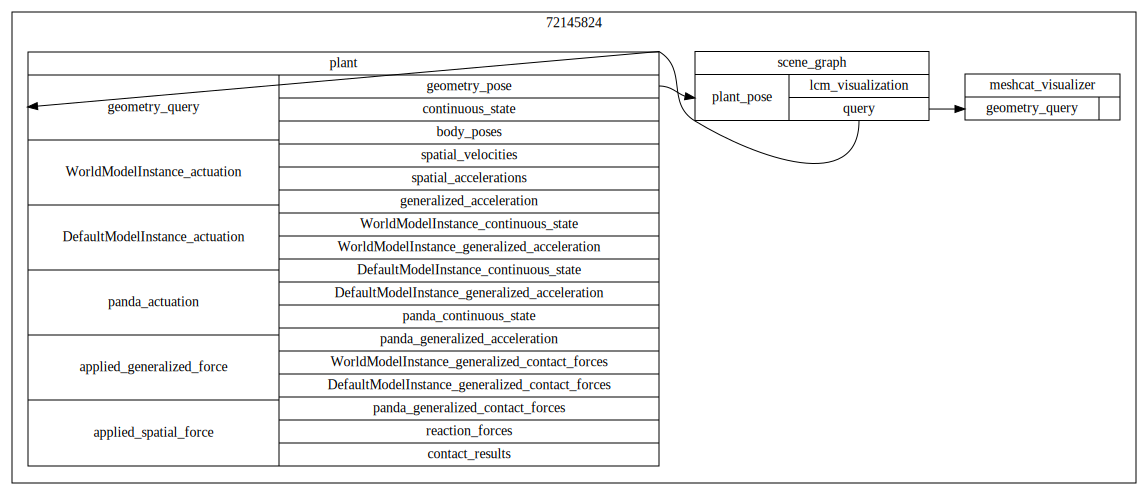

In [12]:
SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg())

In [37]:
plant_context = plant.GetMyMutableContextFromRoot(context)
plant.SetPositions(plant_context, [-1.57, 0.1, 0, -1.2, 0, 1.6, 0,0,0])
plant.get_actuation_input_port().FixValue(plant_context, np.zeros(9))
print(context)

::_ Context (of a Diagram)
---------------------------
18 total discrete states in 1 groups
280 total numeric parameters in 42 groups
1 total abstract parameters

::_::plant Context
-------------------
Time: 0
States:
  1 discrete state groups with
     18 states
       -1.57   0.1     0  -1.2     0   1.6     0     0     0     0     0     0     0     0     0     0     0     0

Parameters:
  42 numeric parameter groups with
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
  

In [14]:
simulator = Simulator(diagram, context)
simulator.set_target_realtime_rate(1.0)
simulator.AdvanceTo(5.0)

In [15]:
builder = DiagramBuilder()

# Adds both MultibodyPlant and the SceneGraph, and wires them together.
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
# Note that we parse into both the plant and the scene_graph here.
Parser(plant, scene_graph).AddModelFromFile(
        FindResourceOrThrow("drake/manipulation/models/franka_description/urdf/panda_arm_hand.urdf"))
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("panda_link0"))
plant.Finalize()

# Adds the MeshcatVisualizer and wires it to the SceneGraph.
meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url, delete_prefix_on_load=False)

diagram = builder.Build()
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(context)
plant.SetPositions(plant_context, [-1.57, 0.1, 0, -1.2, 0, 1.6, 0,0,0])
plant.get_actuation_input_port().FixValue(plant_context, np.zeros(9))

simulator = Simulator(diagram, context)
simulator.set_target_realtime_rate(1.0)

meshcat.start_recording()
simulator.AdvanceTo(5.0)
meshcat.stop_recording()
meshcat.publish_recording()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Connected to meshcat-server.
